In [1]:
import pickle
import numpy as np
from multigraph import MultiGraph

with open('adj_graph.pkl', 'rb') as inobj:
    op_graph = pickle.load(inobj)

In [2]:
import unicodecsv as csv
  
# The AIFB dataset has 176 people and they are associated with one of four affiliations in the organization.
# The completeSet.tsv file gives the URIs of the people and their affiliation
# (number, person, affiliation)
person_dict = {}
with open('aifb_csv/completeDataset.tsv', 'r') as csvfile:
    graphreader = csv.reader(csvfile, delimiter="\t")
    i = 0
    for row in graphreader:
        if i == 0:
            i += 1
            continue
        person_dict[row[1]] = (row[1],row[2])

In [3]:
a_graph = op_graph.get_adjacency_matrix()

In [4]:
import keras
from keras.models import Sequential, Model, model_from_json
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation
#load the saved embeddings
# load json and create model
json_file = open('coding_model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("coding_model.h5")
print("Loaded model from disk")

Using Theano backend.


Loaded model from disk


In [5]:
model.compile(optimizer='adam', loss='mse')
embedding = model.predict(a_graph)

In [6]:
person_embeddings = []
person_labels = []
for person in person_dict:
    person_embeddings.append(embedding[op_graph.nodes[person]])
    label = person_dict[person][1].rsplit('/',2)[-1]
    person_labels.append(label)
person_numbers = dict([(i,j) for j,i in enumerate(set(person_labels))])
labels = [person_numbers[x] for x in person_labels]

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import gensim


#from https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
def tsnescatterplot(vectors, vector_labels):
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # display scatter plot
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords, c=vector_labels)
    

    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

def pcascatterplot(vectors, vector_labels):
            
    # find tsne coords for 2 dimensions
    pca = PCA(n_components=2)
    np.set_printoptions(suppress=True)
    Y = pca.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords, c=vector_labels)
    

    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

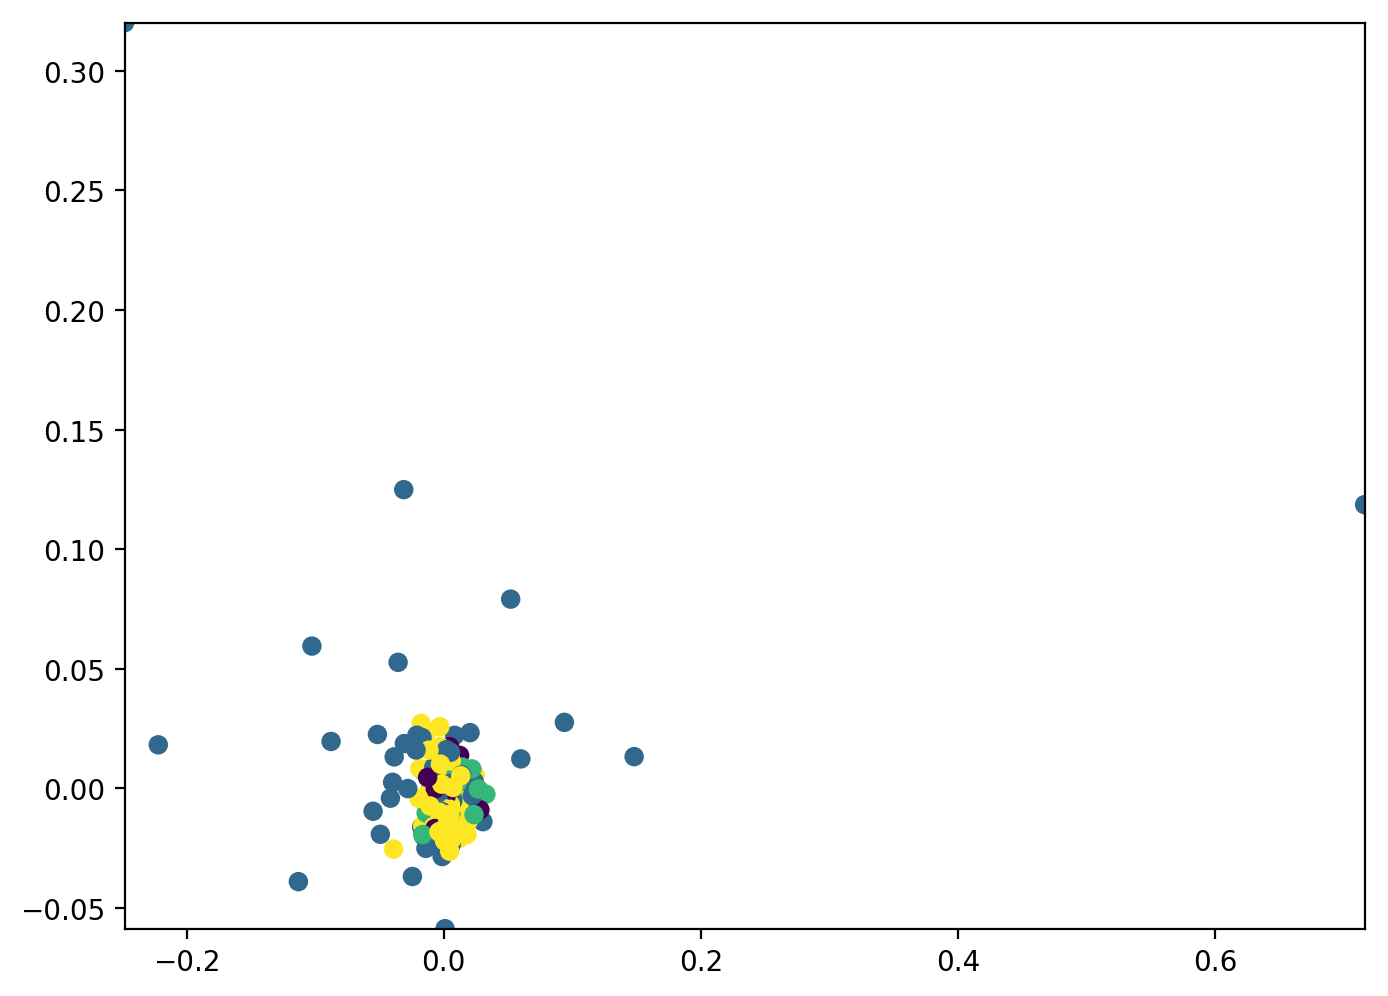

In [8]:
pcascatterplot(person_embeddings, labels)

In [ ]:
tsnescatterplot(person_embeddings, labels)